Here's a detailed documentation of your `EmergencyResponseEnv` environment, explaining each function and variable in the class:

### Class: `EmergencyResponseEnv`

This class represents an environment for simulating and evaluating emergency response strategies within a grid-based setting. It inherits from `gym.Env`, making it compatible with reinforcement learning frameworks.

#### `__init__(self, incident_probabilities, resource_types, stations=None)`
- **Purpose**: Initializes the environment with necessary parameters.
- **Parameters**:
  - `incident_probabilities`: A data structure containing the probabilities of incidents occurring in each grid cell.
  - `resource_types`: A list indicating the type of each emergency resource (e.g., 'A', 'B').
  - `stations` (optional): A list of tuples representing the starting locations of each resource. Defaults to `(0, 0)` if not provided.
- **Key Variables**:
  - `self.grid_size`: The size of one dimension of the square grid.
  - `self.n_cells`: The total number of cells in the grid.
  - `self.resource_types`: Stores the types of resources available.
  - `self.num_resources`: The total number of resources.
  - `self.stations`: The starting locations of resources.
  - `self.resource_locations`: The current locations of the resources, initially set to the stations.
  - `self.action_space`: Defines the possible actions in the environment.
  - `self.observation_space`: Defines the format of observations that the environment provides.
  - `self.state`: Represents the current state of the environment, including incidents.
  - `self.current_time`, `self.current_day`: Track the current time and day in the simulation.

#### `step(self, action)`
- **Purpose**: Advances the environment by one step based on the given action.
- **Parameters**:
  - `action`: A list of actions taken by the resources.
- **Process**:
  - Generates new incidents based on probabilities.
  - Updates the state of the environment based on the actions of resources and their capabilities.
  - Calculates metrics such as response time.
- **Returns**:
  - The new state of the environment, the reward for the taken actions, and flags indicating if the simulation is done.

#### `calculate_travel_time(self, resource_location, incident_location)`
- **Purpose**: Calculates the travel time for a resource to move from its current location to an incident location.
- **Parameters**:
  - `resource_location`: The current location of the resource.
  - `incident_location`: The location of the incident.

#### `grid_cell_to_location(self, cell)`
- **Purpose**: Converts a grid cell number to its corresponding (x, y) location on the grid.
- **Parameters**:
  - `cell`: The grid cell number.

#### `calculate_distance(self, loc1, loc2)`
- **Purpose**: Calculates the distance between two locations.
- **Parameters**:
  - `loc1`, `loc2`: The two locations between which the distance is to be calculated.

#### `is_resource_capable(self, resource_type, incident_location, incident_severity)`
- **Purpose**: Determines if a resource of a given type is capable of addressing an incident based on its location and the incident's severity.
- **Parameters**:
  - `resource_type`: The type of the resource.
  - `incident_location`: The location of the incident.
  - `incident_severity`: The severity of the incident.

#### `reset(self, time='Morning', day='Monday')`
- **Purpose**: Resets the environment to its initial state.
- **Parameters**:
  - `time` (optional): The time of day for the start of the new episode.
  - `day` (optional): The day of the week for the start of the new episode.

#### `render(self, mode='console')`
- **Purpose**: Provides a visual representation of the current state of the environment.
- **Parameters**:
  - `mode`: The mode of rendering; currently, only 'console' mode is supported.

#### `generate_incidents(self)`
- **Purpose**: Generates new incidents with their severity levels based on the incident probabilities.
- **Returns**:
  - A 2D array representing new incidents and their severities in each grid cell.

#### `calculate_metrics(self)`
- **Purpose**: Calculates various metrics to evaluate the performance of emergency response strategies.
- **Returns**:
  - A dictionary containing metrics such as average response time, resolution rate, total incidents responded, and others.

### General Workflow

1. **Initialization**: The environment is initialized with the specified grid size, resource types, stations, and incident probabilities.
2. **Running a Simulation**: The `step` method is called repeatedly to simulate the response to incidents. Actions taken by the agents (resources) are passed to this method.
3. **Metrics Calculation**: After running the simulation for a desired number of steps or episodes, `calculate_metrics` can be called to evaluate

 the performance based on the gathered data.

### Usage

This environment is designed to simulate and evaluate the effectiveness of different emergency response strategies within a grid-based urban setting. It can be used in conjunction with reinforcement learning algorithms to develop and test policies for emergency response management.

In [1]:
import pandas as pd 
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import gymnasium as gym
from gymnasium import spaces
import numpy as np
import random

In [2]:
# Reload the first dataset for a detailed examination
data = pd.read_csv('combined_incidents.csv')

# Display basic information about the dataset
combined_incidents_info = data.info()
combined_incidents_description = data.describe()
combined_incidents_head = data.head()

combined_incidents_info, combined_incidents_description, combined_incidents_head

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 203215 entries, 0 to 203214
Data columns (total 2 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   Grid Cell  203215 non-null  int64 
 1   Timestamp  203215 non-null  object
dtypes: int64(1), object(1)
memory usage: 3.1+ MB


(None,
            Grid Cell
 count  203215.000000
 mean      393.636336
 std       122.901614
 min        23.000000
 25%       345.000000
 50%       405.000000
 75%       406.000000
 max       887.000000,
    Grid Cell                   Timestamp
 0        172  2019-03-27 10:40:12.529245
 1        226  2019-03-27 10:16:42.028122
 2        228  2019-03-27 10:55:01.115513
 3        233  2019-03-27 10:20:15.934103
 4        242  2019-03-27 08:50:32.356951)

In [3]:
data.head()

,Grid Cell,Timestamp
0,172,2019-03-27 10:40:12.529245
1,226,2019-03-27 10:16:42.028122
2,228,2019-03-27 10:55:01.115513
3,233,2019-03-27 10:20:15.934103
4,242,2019-03-27 08:50:32.356951


In [4]:
# Function to categorize the time of day
def categorize_time_of_day(hour):
    if 5 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 17:
        return 'Afternoon'
    elif 17 <= hour < 22:
        return 'Evening'
    else:
        return 'Night'
    
    

# Convert 'Timestamp' to datetime
data['Timestamp'] = pd.to_datetime(data['Timestamp'])
# Convert 'Timestamp' to datetime and extract features
data['Timestamp'] = pd.to_datetime(data['Timestamp'])
data['DayOfWeek'] = data['Timestamp'].dt.day_name()
data['TimeOfDay'] = data['Timestamp'].dt.hour.apply(categorize_time_of_day)
# Extracting features from the timestamp
data['Hour'] = data['Timestamp'].dt.hour
data['Date'] = data['Timestamp'].dt.date
# Display the updated dataset
data.head()

,Grid Cell,Timestamp,DayOfWeek,TimeOfDay,Hour,Date
0,172,2019-03-27 10:40:12.529245,Wednesday,Morning,10,2019-03-27
1,226,2019-03-27 10:16:42.028122,Wednesday,Morning,10,2019-03-27
2,228,2019-03-27 10:55:01.115513,Wednesday,Morning,10,2019-03-27
3,233,2019-03-27 10:20:15.934103,Wednesday,Morning,10,2019-03-27
4,242,2019-03-27 08:50:32.356951,Wednesday,Morning,8,2019-03-27


In [5]:
# Aggregating data by Grid Cell, DayOfWeek, and TimeOfDay
incident_counts = data.groupby(['Grid Cell', 'DayOfWeek', 'TimeOfDay']).size().reset_index(name='IncidentCount')

# Sorting the data for better readability
incident_counts.sort_values(by=['Grid Cell', 'DayOfWeek', 'TimeOfDay'], inplace=True)

# Displaying the aggregated data
incident_counts.head()


,Grid Cell,DayOfWeek,TimeOfDay,IncidentCount
0,23,Friday,Morning,3
1,23,Friday,Night,3
2,23,Monday,Afternoon,1
3,23,Monday,Evening,2
4,23,Monday,Morning,4


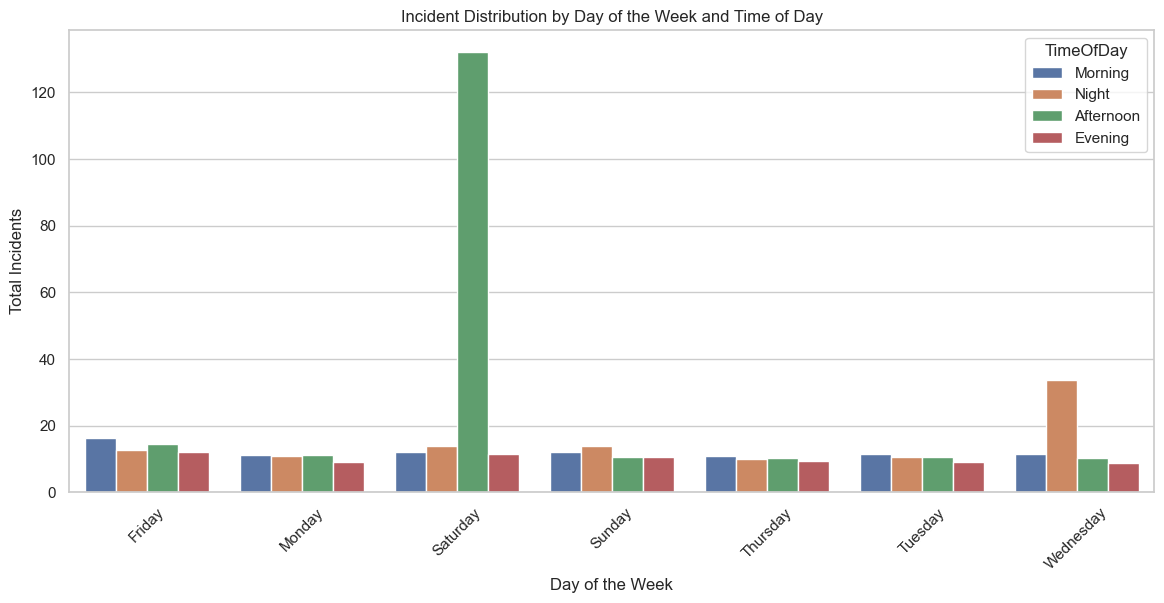

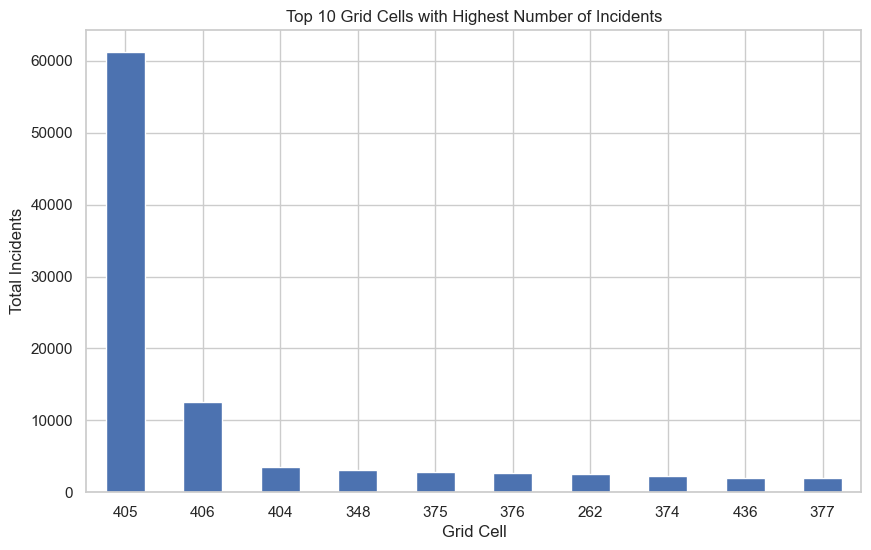

In [6]:
# Setting the aesthetics for the plots
sns.set(style="whitegrid")

# Overall Incident Distribution by Day of the Week and Time of Day
plt.figure(figsize=(14, 6))
sns.barplot(x='DayOfWeek', y='IncidentCount', hue='TimeOfDay', data=incident_counts, errorbar=None)
plt.title('Incident Distribution by Day of the Week and Time of Day')
plt.ylabel('Total Incidents')
plt.xlabel('Day of the Week')
plt.xticks(rotation=45)
plt.show()

# Identifying the Grid Cells with the Highest Number of Incidents
top_grid_cells = incident_counts.groupby('Grid Cell')['IncidentCount'].sum().sort_values(ascending=False).head(10)
plt.figure(figsize=(10, 6))
top_grid_cells.plot(kind='bar')
plt.title('Top 10 Grid Cells with Highest Number of Incidents')
plt.ylabel('Total Incidents')
plt.xlabel('Grid Cell')
plt.xticks(rotation=0)
plt.show()

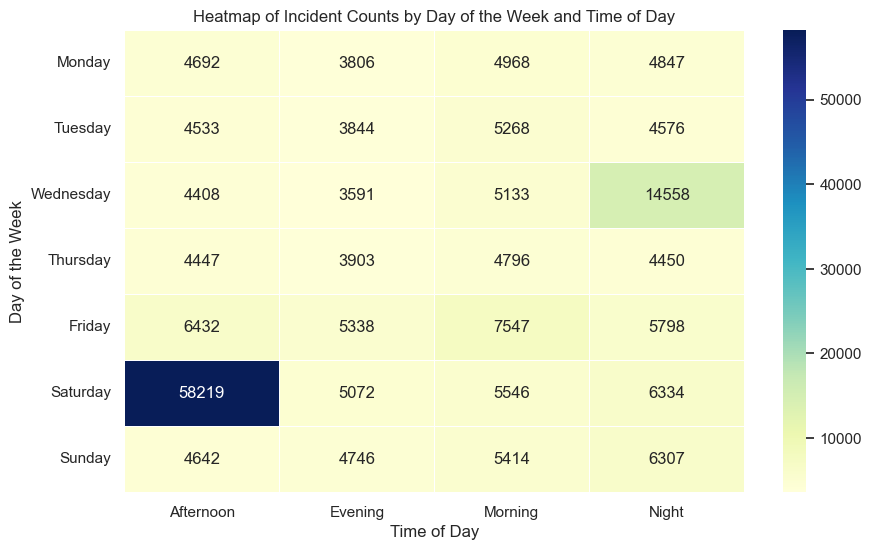

In [7]:
# Creating a pivot table for day and time specific trends
pivot_data = incident_counts.pivot_table(index='DayOfWeek', columns='TimeOfDay', values='IncidentCount', aggfunc='sum')

# Ordering the days of the week
days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
pivot_data = pivot_data.reindex(days_order)

# Plotting the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(pivot_data, annot=True, fmt="d", cmap='YlGnBu', linewidths=.5)
plt.title('Heatmap of Incident Counts by Day of the Week and Time of Day')
plt.ylabel('Day of the Week')
plt.xlabel('Time of Day')
plt.show()


In [8]:
# Calculate the total number of occurrences for each combination of DayOfWeek and TimeOfDay
occurrences = data.groupby(['DayOfWeek', 'TimeOfDay'])['Date'].nunique().reset_index(name='Occurrences')

# Merge occurrences with the aggregated incident data
normalized_data = pd.merge(incident_counts, occurrences, on=['DayOfWeek', 'TimeOfDay'])

# Calculate normalized incident count
normalized_data['NormalizedIncidentCount'] = normalized_data['IncidentCount'] / normalized_data['Occurrences']

# Display the first few rows of the normalized dataset
normalized_data

,Grid Cell,DayOfWeek,TimeOfDay,IncidentCount,Occurrences,NormalizedIncidentCount
0,23,Friday,Morning,3,5,0.6
1,24,Friday,Morning,3,5,0.6
2,51,Friday,Morning,4,5,0.8
3,52,Friday,Morning,5,5,1.0
4,53,Friday,Morning,2,5,0.4
...,...,...,...,...,...,...
12304,848,Friday,Afternoon,3,5,0.6
12305,855,Friday,Afternoon,3,5,0.6
12306,856,Friday,Afternoon,2,5,0.4
12307,857,Friday,Afternoon,1,5,0.2


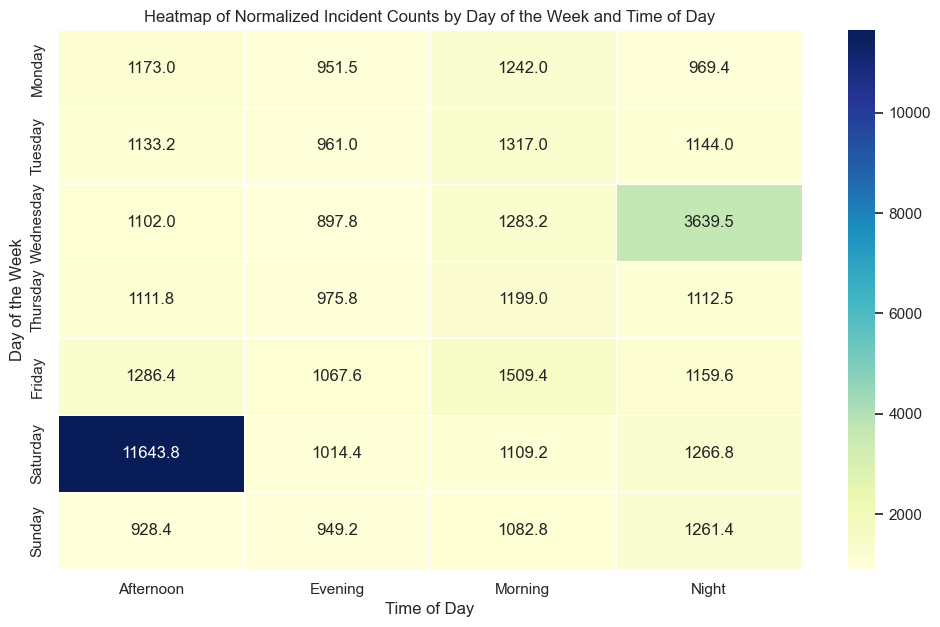

In [9]:
# Creating a pivot table for the heatmap
pivot_data = normalized_data.pivot_table(index='DayOfWeek', columns='TimeOfDay', values='NormalizedIncidentCount', aggfunc='sum')

# Ordering the days of the week for the heatmap
days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
pivot_data = pivot_data.reindex(days_order)

# Plotting the heatmap
plt.figure(figsize=(12, 7))
sns.heatmap(pivot_data, annot=True, fmt=".1f", cmap='YlGnBu', linewidths=.5)
plt.title('Heatmap of Normalized Incident Counts by Day of the Week and Time of Day')
plt.ylabel('Day of the Week')
plt.xlabel('Time of Day')
plt.show()

In [10]:
# Calculate the incident probabilities for each grid cell, time chunk, and day
probabilities = data.groupby(['Grid Cell', 'DayOfWeek', 'TimeOfDay']).size() / data.groupby(['Grid Cell']).size()

# Unstack the probabilities for easier access
probabilities_unstacked = probabilities.unstack(level=['DayOfWeek', 'TimeOfDay']).fillna(0)

probabilities_unstacked.head() 

DayOfWeek    Friday              Monday                                \
TimeOfDay   Morning     Night Afternoon   Evening   Morning     Night   
Grid Cell                                                               
23         0.049180  0.049180  0.016393  0.032787  0.065574  0.065574   
24         0.044118  0.088235  0.044118  0.058824  0.029412  0.073529   
51         0.047059  0.047059  0.035294  0.023529  0.035294  0.011765   
52         0.064103  0.025641  0.038462  0.012821  0.064103  0.051282   
53         0.030769  0.030769  0.046154  0.015385  0.076923  0.061538   

DayOfWeek  Saturday              Sunday            ...   Tuesday Wednesday  \
TimeOfDay Afternoon   Morning Afternoon   Evening  ...     Night Afternoon   
Grid Cell                                          ...                       
23         0.049180  0.032787  0.016393  0.032787  ...  0.032787  0.065574   
24         0.058824  0.014706  0.029412  0.029412  ...  0.088235  0.014706   
51         0.058824  0.094118  0.058824  0.011765  ...  0.023529  0.011765   
52         0.000000  0.064103  0.025641  0.051282  ...  0.064103  0.012821   
53         0.030769  0.030769  0.000000  0.061538  ...  0.046154  0.000000   

DayOfWeek                                  Friday  Saturday            \
TimeOfDay   Evening   Morning     Night   Evening   Evening     Night   
Grid Cell                                                               
23         0.065574  0.049180  0.032787  0.000000  0.000000  0.000000   
24         0.014706  0.058824  0.000000  0.014706  0.029412  0.029412   
51         0.000000  0.035294  0.023529  0.023529  0.023529  0.058824   
52         0.000000  0.038462  0.012821  0.025641  0.025641  0.076923   
53         0.061538  0.000000  0.076923  0.046154  0.015385  0.030769   

DayOfWeek  Thursday    Friday  
TimeOfDay     Night Afternoon  
Grid Cell                      
23         0.000000  0.000000  
24         0.014706  0.000000  
51         0.070588  0.035294  
52         0.025641  0.051282  
53         0.015385  0.046154  

[5 rows x 28 columns]

In [11]:
# Define the total number of grid cells (30x30 grid)
total_cells = 30 * 30

# Creating a complete DataFrame with all grid cells
all_grid_cells = pd.DataFrame(range(total_cells), columns=['Grid Cell'])
probabilities_reset = probabilities_unstacked.reset_index()
flat_columns = ['Grid Cell']
flat_columns.extend([f'{day} {time}' for day, time in probabilities_unstacked.columns])

probabilities_reset.columns = flat_columns

# Merge with the complete grid cells DataFrame
complete_data = all_grid_cells.merge(probabilities_reset, on='Grid Cell', how='left')

# Perform interpolation
#interpolated_data = complete_data.interpolate(method='linear').bfill().ffill()
interpolated_data = complete_data.fillna(0.01)
# Set the 'Grid Cell' back as the index
interpolated_data.set_index('Grid Cell', inplace=True)

interpolated_data.head(52)

,Friday Morning,Friday Night,Monday Afternoon,Monday Evening,Monday Morning,Monday Night,Saturday Afternoon,Saturday Morning,Sunday Afternoon,Sunday Evening,...,Tuesday Night,Wednesday Afternoon,Wednesday Evening,Wednesday Morning,Wednesday Night,Friday Evening,Saturday Evening,Saturday Night,Thursday Night,Friday Afternoon
Grid Cell,,,,,,,,,,,,,,,,,,,,,
0,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,...,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000
1,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,...,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000
2,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,...,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000
3,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,...,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000
4,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,...,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000
5,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,...,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000
6,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,...,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000
7,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,...,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000
8,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,...,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000


In [12]:
class EmergencyResponseEnv(gym.Env):
    def __init__(self, incident_probabilities, resource_types, stations=None):
        super(EmergencyResponseEnv, self).__init__()

        self.grid_size = 30
        self.n_cells = self.grid_size ** 2  # Total number of cells in the grid

        # Resource-specific parameters
        self.resource_types = resource_types  # e.g., ['A', 'B', 'A']
        self.num_resources = len(resource_types)  # Number of resources based on the provided types

        # Define stations for each resource
        if stations is None:
            # Default stations at the origin if not provided
            stations = [(0, 0)] * self.num_resources
        self.stations = stations
        self.resource_locations = np.array(stations)  # Current locations of resources

        # Action and observation space
        # The action space size is equal to the number of resources
        self.action_space = gym.spaces.MultiDiscrete([self.n_cells] * self.num_resources)
        #self.observation_space = gym.spaces.MultiBinary(self.n_cells)
        #self.observation_space = gym.spaces.Box(low=0, high=3, shape=(900, 2), dtype=np.int32)
        self.observation_space = gym.spaces.Box(low=0, high=3, shape=(self.n_cells,), dtype=np.int32)

        # Incident probabilities
        self.incident_probabilities = incident_probabilities
        
        self.max_steps_per_episode = 1  # Example: 50 steps per episode
        self.current_step = 0

        # Initialize state
        self.state = None
        self.current_time = None
        self.current_day = None
        self.cumulative_response_time = 0
        self.incidents_responded = 0
        self.total_incidents = 0
        
        

    def step(self, action):
        
        # Generate new incidents with severity
        new_incidents = self.generate_incidents()
        new_incidents = new_incidents.astype(np.int32)
        #print("Simulated Incidents Incidents with Severity Levels: \n")
        #print(new_incidents[:, 1])#.reshape(self.grid_size, self.grid_size))
        self.total_incidents += np.sum(new_incidents[:, 0])
        time_step = 1
        reward_positive=0
        for idx, resource_idx in enumerate(action):
            resource_type = self.resource_types[idx]
            incident, severity = new_incidents[resource_idx]
            incident_location = self.grid_cell_to_location(resource_idx)

            # Calculate travel time (if needed for the metrics)
            travel_time = self.calculate_travel_time(self.resource_locations[idx], incident_location)

            if incident == 1 and self.is_resource_capable(idx,resource_type, incident_location, severity):
                reward_positive += int(severity) * (1-(travel_time/20))
                #print(reward_positive)
                #print(travel_time )
                new_incidents[resource_idx] = [0, 0]  # Incident addressed
                self.incidents_responded += 1
                self.cumulative_response_time += travel_time
                
        self.state = new_incidents
        self.state = self.state[:, 1]
        self.current_step += 1
        #print(self.current_step)
        # Calculate reward
        reward = float(-sum(incident for incident in self.state if incident) + reward_positive ) # Negative reward for unaddressed incidents

        #done = False
        #done = True
        done = self.current_step >= self.max_steps_per_episode
        #print(done)
        
        #flattened_state = self.state.reshape(-1)  # Flatten the state to a 1D array
        truncated = False
        #return flattened_state, reward, done, {}

        return self.state, reward, truncated, done, {}
    
    def calculate_travel_time(self, resource_location, incident_location):
        # Simplified travel time calculation (e.g., Manhattan distance)
        return np.sum(np.abs(np.array(resource_location) - np.array(incident_location)))
    
    def grid_cell_to_location(self, cell):
        # Convert grid cell number to (x, y) location
        return cell // self.grid_size, cell % self.grid_size
    
    def calculate_distance(self, loc1, loc2):
        return np.sum(np.abs(np.array(loc1) - np.array(loc2)))
    
    def is_resource_capable(self, idx, resource_type, incident_location, incident_severity):        
        station_location = self.stations[idx]
        distance = self.calculate_distance(station_location, incident_location)

        if resource_type == 'A' and distance <= 10:
        #if resource_type == 'A':    
            return True  # Type A can address any incident within 10 grid units
        elif resource_type == 'B' and distance <= 20 and incident_severity == 3 :
        #elif resource_type == 'B':    
            return True  # Type B can address only severity 3 incidents within 20 grid units

        return False
    

    
    def reset(self, seed=None, time='Morning', day='Monday'):
        info = {}
        if seed is not None:
            np.random.seed(seed)
        # Initialize state as a two-dimensional array: [incident flag, severity level]
        self.state = np.zeros((self.n_cells, 2), dtype=int)
        
        self.state = self.state.astype(np.int32)
        self.state = self.state[:, 1]
        self.current_time = time
        self.current_day = day
        self.cumulative_response_time = 0
        self.incidents_responded = 0
        self.total_incidents = 0
        self.current_step = 0
        #flattened_state = self.state.reshape(-1)  # Flatten the state to a 1D array
        return self.state, info
        #return flattened_state

    def render(self, mode='console'):
        if mode != 'console':
            raise NotImplementedError("Only console rendering is supported.")

        # Reshape and render the state
        #incident_grid = self.state[:, 0].reshape(self.grid_size, self.grid_size)
        #severity_grid = self.state[:, 1].reshape(self.grid_size, self.grid_size)


        print("Incidents with Severity Levels after action:\n")
        print(self.state)
        
        
    def generate_incidents(self):
        # Generate incidents with severity levels
        new_incidents = np.zeros((self.n_cells, 2), dtype=int)  # [incident flag, severity level]
        for cell in range(self.n_cells):
            current_prob = self.incident_probabilities.loc[cell, f'{self.current_day} {self.current_time}']
            if np.random.rand() < current_prob:
                severity = np.random.choice([1, 2, 3], p=[0.7, 0.2, 0.1])  # Example probabilities for severity levels
                new_incidents[cell] = [1, severity]  # Incident and its severity
        return new_incidents
    
    
    def calculate_metrics(self):
        average_response_time = (self.cumulative_response_time / self.incidents_responded 
                                 if self.incidents_responded > 0 else float('inf'))
        resolution_rate = self.incidents_responded / self.total_incidents if self.total_incidents > 0 else 0

        return {
            "Total Incidents responded": self.incidents_responded,
            "Total Cumulative Time for responses": self.cumulative_response_time,
            "Total Incidents Recorded": self.total_incidents,
            "Average Response Time": average_response_time,
            "Resolution Rate": resolution_rate,
            
            # Add other metrics as needed
        }

    # Additional methods can be added as needed


In [13]:
# Number of cells along one dimension
#grid_size = 30

# Generate 900 resource types, cycling through 'A' and 'B'
#resource_types = ['A', 'B'] * (900 // 2)
#resource_types = ['B'] * (900)
#resource_types = ['A'] * (900)
# Generate 900 station coordinates
# This will spread stations evenly across the grid
#stations = [(x, y) for x in range(grid_size) for y in range(grid_size)]

In [14]:
# Create an instance of the environment
resource_types = ['A', 'B', 'A', 'B', 'A', 'B', 'A', 'B', 'A', 'B']
stations = [(5, 5), (10, 10), (15, 15), (20, 20), (25, 25), (5, 15), (10, 25), (15, 5), (20, 15), (25, 25)]
env = EmergencyResponseEnv(interpolated_data, resource_types, stations)

# Number of steps for the simulation
num_steps = 1  # or more, as needed

# Run the simulation
env.reset(time='Afternoon', day='Saturday')
for _ in range(num_steps):
    print(f"\n\n\n\n----- Step {_ + 1} -----\n")
    action = np.random.choice(env.n_cells, env.num_resources, replace=False)
    state, reward, done, truncated, info = env.step(action)
    print("\n Action taken: \n")
    print(list(action))
    print()
    env.render()
    print("\nReward:", reward)

    # Calculate and display the metrics
    metrics = env.calculate_metrics()
    print("Metrics after simulation:")
    print(f"Total Incidents responded: {metrics['Total Incidents responded']}")
    print(f"Total Cumulative Time for responses: {metrics['Total Cumulative Time for responses']}")
    print(f"Total Incidents Recorded: {metrics['Total Incidents Recorded']}")
    print(f"Average Response Time: {metrics['Average Response Time']}")
    print(f"Resolution Rate: {metrics['Resolution Rate']}")

    # Add other metrics as they are implemented






----- Step 1 -----


 Action taken: 

[323, 509, 377, 877, 770, 165, 629, 363, 324, 120]

Incidents with Severity Levels after action:

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0
 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 1 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 1 0
 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

In [15]:
from stable_baselines3 import PPO
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.evaluation import evaluate_policy

In [16]:
# Number of cells along one dimension
#grid_size = 30

# Generate 900 resource types, cycling through 'A' and 'B'
#resource_types = ['A', 'B'] * (900 // 2)
#resource_types = ['B'] * (900)
#resource_types = ['A'] * (900)
# Generate 900 station coordinates
# This will spread stations evenly across the grid
#stations = [(x, y) for x in range(grid_size) for y in range(grid_size)]

In [17]:
# Create an instance of the environment
resource_types = ['A', 'B', 'A']
stations = [(5, 5), (10, 10), (15, 15)]
#resource_types = ['A', 'B', 'A', 'B', 'A', 'B', 'A', 'B', 'A', 'B']
#stations = [(5, 5), (10, 10), (15, 15), (20, 20), (25, 25), (5, 15), (10, 25), (15, 5), (20, 15), (25, 25)]
env = EmergencyResponseEnv(interpolated_data, resource_types, stations)
#env.reset(time='Afternoon', day='Saturday')

(array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [18]:
check_env(env)

In [19]:
# Create the environment
env = make_vec_env(lambda: EmergencyResponseEnv(interpolated_data, resource_types, stations), n_envs=1)

In [20]:
model = PPO("MlpPolicy", env, verbose=1)


Using cpu device


In [21]:
model.learn(total_timesteps=10000)  # You can adjust the total timesteps


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1        |
|    ep_rew_mean     | -29.5    |
| time/              |          |
|    fps             | 127      |
|    iterations      | 1        |
|    time_elapsed    | 16       |
|    total_timesteps | 2048     |
---------------------------------
-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 1             |
|    ep_rew_mean          | -30.7         |
| time/                   |               |
|    fps                  | 119           |
|    iterations           | 2             |
|    time_elapsed         | 34            |
|    total_timesteps      | 4096          |
| train/                  |               |
|    approx_kl            | 0.00011443559 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -20.4         |
|    explained_variance   | 0             |


In [22]:
mean_reward, std_reward = evaluate_policy(model, env, n_eval_episodes=100)
print(f"Mean reward: {mean_reward} +/- {std_reward}")


Mean reward: -30.85 +/- 7.450335562912587


In [23]:
model.save("ppo_emergency_response")
del model  # remove to demonstrate saving and loading

model = PPO.load("ppo_emergency_response")


In [24]:
# Assuming 'obs' is your current environment observation
obs = env.reset()
action, _states = model.predict(obs, deterministic=True)
print(f"Optimal action for the given observation: {action}")


Optimal action for the given observation: [[203 147 105]]
